# Tutorial 3.1. Creating "Binless" Schemes: Na<sup>+</sup>/Cl<sup>-</sup> Association Simulations
Author: Jeremy Leung<br>
Email:&nbsp;&nbsp; jml230@pitt.edu

## Introduction

This document is a companion jupyter notebook for first tutorial in the WESTPA 2.0 Suite of Tutorials. It involves running a Na<sup>+</sup>/Cl<sup>-</sup> association simulation using WESTPA's new binless resampler module and other advanced analysis suites. Upon completion of this tutorial, a user should be able to initiate WE simulations from multiple basis states and customize their own binless scheme. This tutorial builds upon the basics explained in the Na<sup>+</sup>/Cl<sup>-</sup> tutorial of the original suite of tutorials on LiveCoMS ([Bogetti et al., 2019](https://www.livecomsjournal.org/index.php/livecoms/article/view/v1i2e10607)) and readers are advised to refer to that document as necessary. 

## Learning Objectives
- Learn to customize WESTPA's new binless resampler module.
- Run a WE simulation using the "group by history" scheme.
- How to use multiple basis states in a WE simulation and visualize its coverage.
- Concatinate multiple west.h5 files using <code>w_multi_west</code>.

## System Requirements
- OpenMM and MDTraj are necessary to run this simulation.
    - Note that MDTraj is a dependency of WESTPA 2.0.
- numpy, matplotlib, ipympyl, mdtraj, and nglview are used in this jupyter notebook. 
    - nglview, matplotlib, ipympl, and numpy are optional for visualization purposes.

## Running the Simulation

The files to initialize and run the WESTPA simulation are included with this jupyter notebook as a demo/example. **It is not recommended that you run your WE simulations within a Jupyter Notebook.** The simulation will take a while so feel free to stop it at the run stage. Sample completed files for analysis are provided in the for_analysis/ directory.

In [ ]:
import os
import shutil
# Clean up from previous/ failed simulations.
for i in ['west.h5', 'seg_logs', 'traj_segs','istates']:
    try:
        os.remove(i)
    except OSError:
        try:
            shutil.rmtree(i)
        except OSError:
            pass
        
for i in ['seg_logs','traj_segs','istates']:
    os.mkdir(i)

In [ ]:
import westpa
import numpy
from westpa.cli.core import w_init

# Initializing the System:
class Params:
    def __init__(self):
        pass

# Set some parameters that WESTPA needs to set simulation state.
args = Params()
args.rcfile = 'west.cfg'
args.verbosity = "verbose" ## change to debug if you want a more detailed view of what's happening. 

# Update westpa.rc with these
westpa.rc.process_args(args)

# Initialize the simulation using the tstate and bstate files
w_init.initialize(tstates=None, bstates=None, 
                  tstate_file='tstate.file', bstate_file='bstates/bstates.txt', 
                  segs_per_state=5, shotgun=False)

In [ ]:
import westpa
import numpy
from westpa.cli.core import w_run
import westpa.work_managers as work_managers

# Running the Simulation.
class Params:
    def __init__(self):
        pass

# Set some parameters that WESTPA needs to set simulation state.
args = Params()
args.rcfile = 'west.cfg'
args.verbosity = "verbose"
args.work_manager = 'threads'

# Update westpa.rc with these
westpa.rc.process_args(args)
# Prepare work manager
work_managers.environment.process_wm_args(args)

# Launch the simulation
w_run.run_simulation()

## Monitoring the WE Simulation

The following sample code runs <code>w_pdist</code> and <code>plothist</code> to generate a probability distribution.

In [5]:
import tarfile

# Untar the files for analysis
for file in ['./for_analysis/nacl.hdf5.h5.1.tar.gz']:
    with tarfile.open(file) as tar_f:
        tar_f.extractall('./for_analysis')

In [ ]:
# Generate the pdist.h5
!{'w_pdist -W ./for_analysis/01/west.h5'}

In [7]:
# Generate the average hist.pdf
!{'plothist evolution -o evol.pdf pdist.h5'}

In [8]:
# View the average probability distribution
from IPython.display import IFrame, display
filepath = "evol.pdf"
IFrame(filepath, width=700, height=400)

In [9]:
# Generate the average hist.pdf
!{'plothist average -o avg.pdf pdist.h5 0'}

In [10]:
# View the average probability distribution
from IPython.display import IFrame, display
filepath = "avg.pdf"
IFrame(filepath, width=700, height=400)

## Analyzing the WE Simulation

### Visualization of the System

We will now take a look at how one of the basis states looks like. The water box is omitted for visibility. Na<sup>+</sup> is red and Cl<sup>-</sup> is blue in the representation.

In [1]:
import mdtraj
import nglview
system = mdtraj.load('bstates/01/basis.xml', top='common_files/bstate.pdb')
Na = list(range(0,1)) # Na+ is the first atom
Cl = list(range(1,2)) # Cl- is the second atom
both = Na + Cl # Na+ + Cl-
system = system.atom_slice(both)
view = nglview.show_mdtraj(system)
view.representations = [
    {"type": "ball+stick", "params": {
        "sele": ".Na+", "color": "red"
    }},
    {"type": "ball+stick", "params": {
        "sele": ".Cl-", "color": "blue"
    }}
]
view.background = 'white'
view

NGLWidget()

### Visualization of Coverage of the Basis States

The following cells plots the multiple basis states in a way that allows us to examine  their spacial coverage. The first cell visualizes the system one-by-one after alignment to Na<sup>+</sup>. The second cell plots all the center-of-masses at once.

Do note that many lines are not necessary for Na<sup>+</sup>/Cl</sup>-</sup> as it is spherically symmetrical, and that its center of mass is equal to its coordinate. Extra code is provided so it could be generalized to larger systems.

In [2]:
import numpy
import mdtraj
import nglview
lst = numpy.loadtxt('bstates/bstates.txt', usecols=2, dtype=str) # Reading basis state names
tpg = 'common_files/bstate.pdb' # Topology File for basis state (Shared between all bstates)
lst = [x + "/basis.xml" for x in lst] # Change path to point to file name

# Reading reference and setup
# There might be some warnings about unconverged rotation matrices because of the system's rotational symmetry

com = [] # list containing all CoM
a = mdtraj.load('bstates/01/basis.xml', top=tpg) # Load the first
a_slice = a.atom_slice([0,1]) # Just Na+
com.append(numpy.squeeze(mdtraj.compute_center_of_mass(a_slice))) # Save CoM of Na+
a_slice = a.atom_slice([0,1]) # Both Na+/Cl-

# Loading and superposing, storing Center of Mass (CoM) to list for heatmap
c = a_slice
for i in lst:
    b = mdtraj.load('bstates/' + i, top=tpg)
    b = b.atom_slice([0,1])
    b.superpose(a_slice, atom_indices=[0])
    c = mdtraj.join([c,b], check_topology=False)
    # Just saving the CoM of Cl-, since Na+ is superimposed
    com.append(numpy.squeeze(mdtraj.compute_center_of_mass(b.atom_slice([1]))))
com = numpy.asarray(com)

# Now displaying it, note that Cl- is not visible in some frames unless you rotate the camera
view2 = nglview.show_mdtraj(c)
view2.representations = [
    {"type": "ball+stick", "params": {
        "sele": ".Na+", "color": "red"
    }},
    {"type": "ball+stick", "params": {
        "sele": ".Cl-", "color": "blue"
    }}
]
view2.center('.Na+')
view2.control.zoom(-1.75)
view2

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296


NGLWidget(max_frame=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
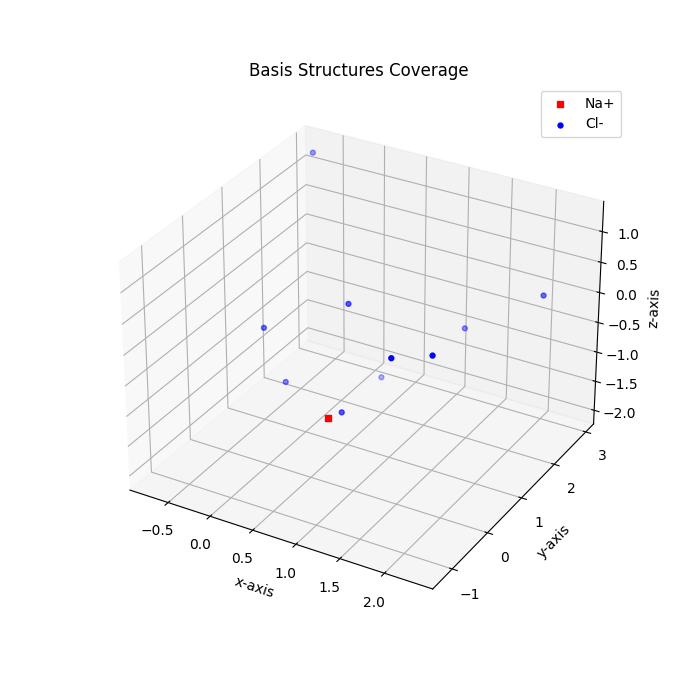

In [3]:
# Looking at the coverage of the bstates, assuming you ran the previous 2 cells
# Comment out the following line or install ipypml if you have trouble viewing.
%matplotlib widget 
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import numpy

fig = matplotlib.pyplot.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

img1 = ax.scatter(com[0,0], com[0,1], com[0,2], s=20, marker='s', color='Red', label='Na+')
img2 = ax.scatter(com[1:,0], com[1:,1], com[1:,2], s=50, marker='.', color='Blue', label='Cl-')

# Labels and Titles
ax.set_title("Basis Structures Coverage")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.legend()

show()

Due to the rotational symmetry, it might be better to look at the Na<sup>+</sup>/Cl<sup>-</sup> atom-to-atom distances instead, which are already precalculated in each pcoord.init file.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
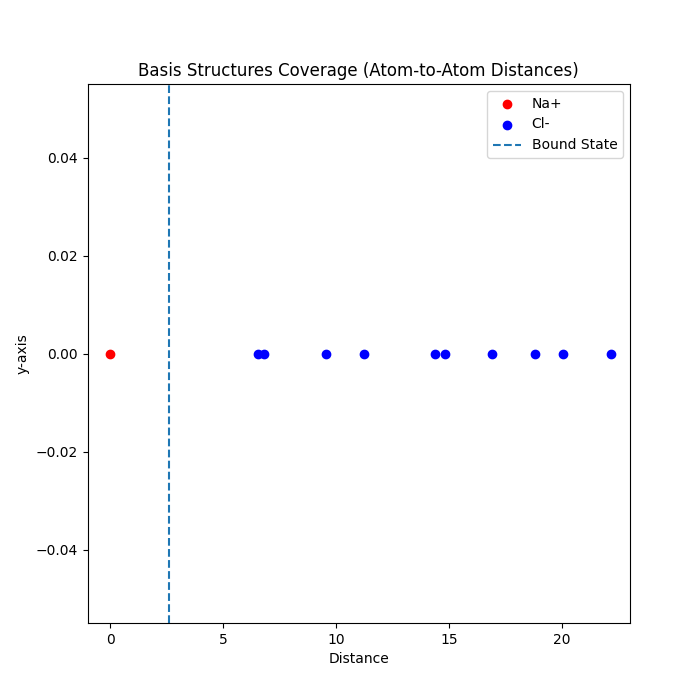

In [4]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
lst = numpy.loadtxt('bstates/bstates.txt', usecols=2, dtype=str) # Reading basis state names
lst2 = ["bstates/" + x + "/pcoord.init" for x in lst] # Change path to point to file name

values = numpy.asarray([numpy.loadtxt(x) for x in lst2])

fig2 = matplotlib.pyplot.figure(figsize=(7,7))
ax2 = fig2.subplots()

img3 = ax2.scatter(0, 0, color='Red', label='Na+')
img4 = ax2.scatter(values[:], numpy.zeros(values.shape[0]), color='Blue', label='Cl-')
img5 = ax2.axvline(x=2.6, ymin=0, ymax=1, label='Bound State', linestyle='--')

# Labels and Titles
ax2.set_title("Basis Structures Coverage (Atom-to-Atom Distances)")
ax2.set_xlabel('Distance')
ax2.set_ylabel('y-axis')
ax2.legend()
plt.xlim(-1,23)

plt.show()

### Calculating Rates

In [5]:
import tarfile
from os import symlink

# Untar the files for analysis
for file in ['./for_analysis/nacl.hdf5.h5.1.tar.gz']:
    with tarfile.open(file) as tar_f:
        tar_f.extractall('./for_analysis')

symlink('./for_analysis/01/west.h5', './west.h5')

In [6]:
from westpa.cli.tools import w_ipa
import westpa

# Initializing the System:
class Params:
    def __init__(self):
        pass

w = w_ipa.WIPI()
w.main()
w.interface = 'matplotlib'


Welcome to w_ipa (WESTPA Interactive Python Analysis) v. 1.0B!
Run w.introduction for a more thorough introduction, or w.help to see a list of options.
Running analysis & loading files.
Reanalyzing file assign.h5 for scheme TEST.
Initializing...
Scanning for segment and point counts...
Preparing output...
Assigning to bins...
Reanalyzing file direct.h5 for scheme TEST.
Initializing...
Tracing trajectories...
Calculating Rate Evolution...
Calculating Conditional Flux Evolution...
Calculating Target Flux Evolution...
Calculating Rate Evolution...
Calculating Conditional Flux Evolution...
Calculating Target Flux Evolution...
Calculating Color Probability Evolution...
Calculating State Probability Evolution...
Calculating Color Probability Evolution...
Calculating State Probability Evolution...

Complete!
Setting iteration to iter 100.
Your current scheme, system and iteration are : TEST, /home/jml230/git/westpa2_tutorials/basic_nacl, 100


## Managing Your Simulations

### Combining Multiple Simulation Runs

The following sample code runs <code>w_multi_west</code> to concatenate two runs.

In [ ]:
import tarfile

# Untar the files
for file in ['./for_analysis/nacl.hdf5.h5.1.tar.gz','./for_analysis/nacl.hdf5.h5.2.tar.gz']:
    with tarfile.open(file) as tar_f:
        tar_f.extractall('./for_analysis')

In [ ]:
# Run w_multi_west in the commandline
!{'w_multi_west -m ./for_analysis/ -n 2'}
print('Done!')

In [ ]:
# Check to see if the multi.h5 file exists
from os.path import exists
exists('multi.h5')

### Using <code>w_crawl</code> to calculate post-simulation auxiliary data

The following sample code runs <code>w_crawl</code> to calculate additional observables post-simulation.

In [ ]:
import tarfile

# Untar the files
for file in ['./for_analysis/nacl.hdf5.h5.1.tar.gz']:
    with tarfile.open(file) as tar_f:
        tar_f.extractall('./for_analysis')

In [ ]:
# Run w_multi_west in the commandline
!{'./run_w_crawl.sh'}
print('Done!')

## Cleaning Up

In [11]:
# Run the following bash script to revert your tutorial folder to pristine condition.
!{'./1.clean.sh'}